In [3]:
def cnt_agree(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k.
    """
    maxk = min(max(topk), output.size()[1])

    output = torch.softmax(-(output - 1)**2,  dim=-1)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    return torch.sum(correct).item()

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from utils.data_utils import Custom_dataset
from model_diffusion import Diffusion
from utils.model_SimCLR import SimCLR_encoder
from utils.clip_wrapper import clip_img_wrap
import os

# Define configuration dictionary instead of argparse
args = {
    "noise_type": "cifar10-pmd-0.35",
    "batch_size": 200,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "feature_dim": 512,
    "k": 100,
    "alpha": 0.3,
    "ddim_n_step": 10,
    "fp_encoder": "CLIP",  # Change to "SimCLR" if you're using SimCLR
    "CLIP_type": "ViT-L/14",
    "diff_encoder": "resnet34",
    "seed": 123
}

def initialize_fp_encoder(fp_encoder_type, device, dataset):
    if fp_encoder_type == 'SimCLR':
        fp_encoder = SimCLR_encoder(feature_dim=128).to(device)
        state_dict = torch.load(f'./model/SimCLR_128_{dataset}.pt', map_location=device)
        fp_encoder.load_state_dict(state_dict, strict=False)
    elif fp_encoder_type == 'CLIP':
        clip_model_path = './model/CLIP_ViT-L14_cifar10.pt'
        if os.path.exists(clip_model_path):
            fp_encoder = torch.load(clip_model_path, map_location=device)
            print(f'Loaded CLIP model from {clip_model_path}')
        else:
            fp_encoder = clip_img_wrap(args["CLIP_type"], device, center=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
            torch.save(fp_encoder, clip_model_path)
            print(f'Saved CLIP model to {clip_model_path}')
    else:
        raise ValueError("fp_encoder should be SimCLR or CLIP")
    
    fp_encoder.eval()  # Set to evaluation mode
    fp_dim = fp_encoder.dim  # Ensure fp_dim matches the encoder's dimensionality
    return fp_encoder, fp_dim

def load_model(model_path, device, n_class, args):
    # Initialize fp_encoder and fp_dim
    fp_encoder, fp_dim = initialize_fp_encoder(args["fp_encoder"], device, dataset="cifar10")
    
    # Pass fp_dim to the diffusion model
    diffusion_model = Diffusion(fp_encoder=fp_encoder, n_class=n_class, fp_dim=fp_dim, 
                                feature_dim=args["feature_dim"], device=device, 
                                encoder_type=args["diff_encoder"], ddim_num_steps=args["ddim_n_step"])
    
    # Load saved model weights with strict=False to allow shape mismatches
    states = torch.load(model_path, map_location=device)
    diffusion_model.model.load_state_dict(states[0], strict=False)
    diffusion_model.diffusion_encoder.load_state_dict(states[1], strict=False)
    diffusion_model.fp_encoder.load_state_dict(states[2], strict=False)
    
    diffusion_model.model.eval()
    return diffusion_model

def get_test_loader(test_data, batch_size):
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    test_dataset = Custom_dataset(test_data.data, test_data.targets, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return test_loader

def run_inference(diffusion_model, test_loader, device):
    correct_cnt = 0
    all_cnt = 0
    with torch.no_grad():
        for images, target, _ in test_loader:
            images, target = images.to(device), target.to(device)
            label_t_0 = diffusion_model.reverse_ddim(images, stochastic=False, fq_x=None).detach().cpu()
            correct = cnt_agree(label_t_0, target.cpu())  # `cnt_agree` calculates the number of correct predictions
            correct_cnt += correct
            all_cnt += images.shape[0]

    print(correct_cnt, all_cnt)
    accuracy = 100 * correct_cnt / all_cnt
    print(f'Inference accuracy: {accuracy:.2f}%')
    return accuracy

# Set device
device = args["device"]
n_class = 100  # Set based on your dataset (e.g., 10 for CIFAR-10)
fp_dim = 512  # Set based on your model setup
model_path = "./model/LRA-diffusion_CLIP_cifar100-cluster-0.35.pt"  # Path to your saved model

# Load model
diffusion_model = load_model(model_path, device, n_class, args)

# Prepare test data and loader (example using CIFAR-10)
test_data = torchvision.datasets.CIFAR100(root='./', train=False, download=True)
test_loader = get_test_loader(test_data, args["batch_size"])

# Run inference
run_inference(diffusion_model, test_loader, device)

Loaded CLIP model from ./model/CLIP_ViT-L14_cifar10.pt
Files already downloaded and verified
5082 10000
Inference accuracy: 50.82%


50.82

In [5]:
import pandas as pd
import torch

# Function to generate predictions for the entire test dataset
def generate_predictions(diffusion_model, test_loader, device):
    results = []
    diffusion_model.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():
        for batch_idx, (images, targets, indices) in enumerate(test_loader):
            images, targets = images.to(device), targets.to(device)
            label_t_0 = diffusion_model.reverse_ddim(images, stochastic=False, fq_x=None).detach().cpu()
            predictions = label_t_0.argmax(dim=1)  # Assuming label_t_0 contains logits for classification
            
            # Append results for each sample in batch
            for i in range(len(images)):
                results.append({
                    'cifar10_test_idx': indices[i].item(),
                    'cifar10_label': targets[i].item(),
                    'model_prediction': predictions[i].item()
                })
    
    return pd.DataFrame(results)

# Generate predictions DataFrame and save to spreadsheet
results_df = generate_predictions(diffusion_model, test_loader, device)
results_df.to_csv("cifar10_test_predictions.csv", index=False)

Loaded CLIP model from ./model/CLIP_ViT_cifar100.pt
Loaded CLIP model from ./model/CLIP_ViT_cifar100.pt
Files already downloaded and verified


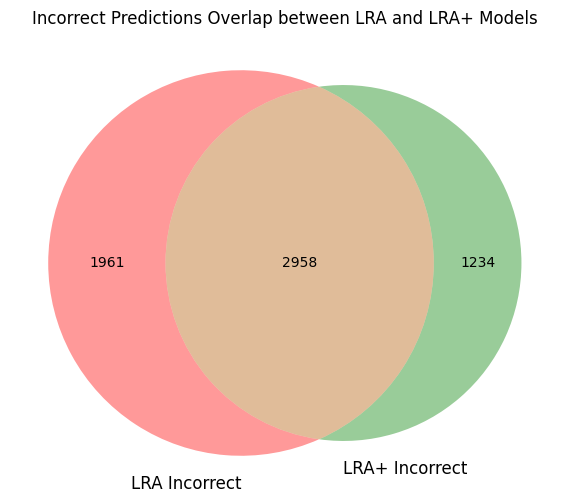

In [6]:
# import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from utils.data_utils import Custom_dataset
from model_diffusion import Diffusion
from utils.model_SimCLR import SimCLR_encoder
from utils.clip_wrapper import clip_img_wrap
import os

# Define configuration dictionary
args = {
    "noise_type": "cifar10-pmd-0.35",
    "batch_size": 200,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "feature_dim": 512,
    "k": 100,
    "alpha": 0.3,
    "ddim_n_step": 10,
    "fp_encoder": "CLIP",
    "CLIP_type": "ViT-L/14",
    "diff_encoder": "resnet34",
    "seed": 123
}

def initialize_fp_encoder(fp_encoder_type, device, dataset):
    if fp_encoder_type == 'SimCLR':
        fp_encoder = SimCLR_encoder(feature_dim=128).to(device)
        state_dict = torch.load(f'./model/SimCLR_128_{dataset}.pt', map_location=device)
        fp_encoder.load_state_dict(state_dict, strict=False)
    elif fp_encoder_type == 'CLIP':
        clip_model_path = './model/CLIP_ViT_cifar100.pt'
        if os.path.exists(clip_model_path):
            fp_encoder = torch.load(clip_model_path, map_location=device)
            print(f'Loaded CLIP model from {clip_model_path}')
        else:
            fp_encoder = clip_img_wrap(args["CLIP_type"], device, center=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
            torch.save(fp_encoder, clip_model_path)
            print(f'Saved CLIP model to {clip_model_path}')
    else:
        raise ValueError("fp_encoder should be SimCLR or CLIP")
    
    fp_encoder.eval()
    fp_dim = fp_encoder.dim
    return fp_encoder, fp_dim

def load_model(model_path, device, n_class, args):
    fp_encoder, fp_dim = initialize_fp_encoder(args["fp_encoder"], device, dataset="cifar10")
    diffusion_model = Diffusion(fp_encoder=fp_encoder, n_class=n_class, fp_dim=fp_dim, 
                                feature_dim=args["feature_dim"], device=device, 
                                encoder_type=args["diff_encoder"], ddim_num_steps=args["ddim_n_step"])
    
    states = torch.load(model_path, map_location=device)
    diffusion_model.model.load_state_dict(states[0], strict=False)
    diffusion_model.diffusion_encoder.load_state_dict(states[1], strict=False)
    diffusion_model.fp_encoder.load_state_dict(states[2], strict=False)
    
    diffusion_model.model.eval()
    return diffusion_model

def cnt_agree(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k.
    """
    maxk = min(max(topk), output.size()[1])
    output = torch.softmax(-(output - 1)**2, dim=-1)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return torch.sum(correct).item()

def get_test_loader(test_data, batch_size):
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    test_dataset = Custom_dataset(test_data.data, test_data.targets, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return test_loader

def get_incorrect_predictions(diffusion_model, test_loader, device):
    incorrect_predictions = set()
    with torch.no_grad():
        for batch_idx, (images, targets, indices) in enumerate(test_loader):
            images, targets = images.to(device), targets.to(device)
            outputs = diffusion_model.reverse_ddim(images, stochastic=False, fq_x=None).detach().cpu()
            predictions = outputs.argmax(dim=1)
            incorrect = indices[predictions != targets.cpu()]
            incorrect_predictions.update(incorrect.tolist())
    return incorrect_predictions

# Set device and load models
device = args["device"]
n_class = 100
model_path_lra = "./model/LRA-diffusion_CLIP_cifar100-cluster-0.35.pt"
model_path_lra_plus = "./model/LRA+-diffusion_CLIP_cifar100-cluster-0.35.pt"

lra_model = load_model(model_path_lra, device, n_class, args)
lra_plus_model = load_model(model_path_lra_plus, device, n_class, args)

# Prepare test data and loader
test_data = torchvision.datasets.CIFAR100(root='./', train=False, download=True)
test_loader = get_test_loader(test_data, args["batch_size"])

# Collect incorrect predictions from each model
incorrect_lra = get_incorrect_predictions(lra_model, test_loader, device)
incorrect_lra_plus = get_incorrect_predictions(lra_plus_model, test_loader, device)

# Create Venn diagram to visualize overlap of incorrect predictions
plt.figure(figsize=(8, 6))
venn2([incorrect_lra, incorrect_lra_plus], ('LRA Incorrect', 'LRA+ Incorrect'))
plt.title("Incorrect Predictions Overlap between LRA and LRA+ Models")
plt.show()

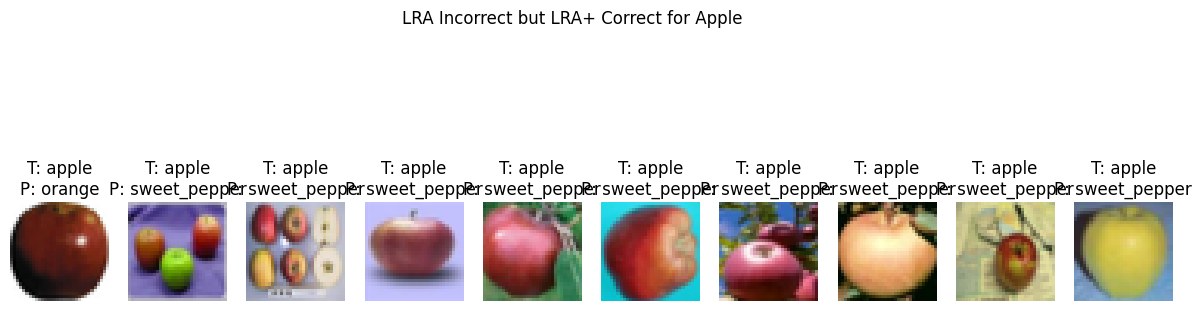

In [21]:
def visualize_category_differences(category, incorrect_lra, incorrect_lra_plus, test_data, lra_model, device, title):
    """
    Visualize images for a given category where LRA was incorrect but LRA+ was correct, 
    showing both the true label and the LRA predicted label.
    """
    # Get the class index for the specified category
    try:
        category_idx = test_data.classes.index(category)
    except ValueError:
        print(f"Category '{category}' not found in CIFAR-100 classes.")
        return

    # Filter indices for the specified category
    category_indices = {i for i, target in enumerate(test_data.targets) if target == category_idx}
    
    # Find indices where LRA was incorrect, but LRA+ was correct
    exclusive_to_lra = (incorrect_lra - incorrect_lra_plus) & category_indices
    
    if not exclusive_to_lra:
        print(f"No samples found for category '{category}' where LRA was incorrect but LRA+ was correct.")
        return

    # Visualize up to 10 examples
    num_images = min(len(exclusive_to_lra), 10)
    indices_to_visualize = list(exclusive_to_lra)[:num_images]
    
    # Extract images and labels
    images = [test_data.data[idx] for idx in indices_to_visualize]
    true_labels = [test_data.classes[test_data.targets[idx]] for idx in indices_to_visualize]
    
    # Compute predictions for these indices
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    lra_predictions = []
    lra_model.eval()
    with torch.no_grad():
        for idx in indices_to_visualize:
            img_tensor = transform_test(test_data.data[idx]).unsqueeze(0).to(device)
            output = lra_model.reverse_ddim(img_tensor, stochastic=False, fq_x=None)
            pred_label = output.argmax(dim=1).item()
            lra_predictions.append(test_data.classes[pred_label])
    
    # Display images
    plt.figure(figsize=(15, 5))
    for i, (img, true_label, lra_label) in enumerate(zip(images, true_labels, lra_predictions)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"T: {true_label}\nP: {lra_label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Specify category and visualize images
category = "apple"  # Replace with your desired category
visualize_category_differences(category, incorrect_lra, incorrect_lra_plus, test_data, lra_model, 
                               device, f"LRA Incorrect but LRA+ Correct for {category.capitalize()}")